In [5]:
!pip install pymongo

In [6]:
import pandas as pd
from datetime import datetime
from pymongo import MongoClient


In [7]:
# Load CSV files
trip_data = pd.read_csv('taxi_trip_data.csv')
zone_data = pd.read_csv('taxi_zone_geo.csv')

In [8]:
# a) Remove the columns “store_and_fwd_flag”, “rate_code” and “total_amount” from taxitripdata
trip_data = trip_data.drop(['store_and_fwd_flag', 'rate_code', 'total_amount'], axis=1)


In [ ]:
trip_data.isnull().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
payment_type           0
fare_amount            0
extra                  0
mta_tax                1
tip_amount             1
tolls_amount           1
imp_surcharge          1
pickup_location_id     1
dropoff_location_id    1
dtype: int64

In [ ]:
zone_data.isnull().sum()

zone_id      0
zone_name    0
borough      0
zone_geom    0
dtype: int64

In [ ]:
# b) Drop rows with missing details
trip_data = trip_data.dropna()


In [ ]:
trip_data.isnull().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
pickup_location_id     0
dropoff_location_id    0
dtype: int64

In [ ]:
trip_data_records = trip_data.head(20000).to_dict(orient='records')

In [10]:
import pymongo
from pymongo import MongoClient
import urllib.parse
from bson.json_util import dumps

# Connect to the MongoDB server
client = MongoClient('<<URL>>')
db = client['cluster0']

In [11]:


# Create a collection
collection_name = 'taxi'
collection = db[collection_name]


In [ ]:


# c) Insert documents into db
collection.insert_many(trip_data_records)


InsertManyResult([ObjectId('65f09cbf694813662d9defc0'), ObjectId('65f09cbf694813662d9defc1'), ObjectId('65f09cbf694813662d9defc2'), ObjectId('65f09cbf694813662d9defc3'), ObjectId('65f09cbf694813662d9defc4'), ObjectId('65f09cbf694813662d9defc5'), ObjectId('65f09cbf694813662d9defc6'), ObjectId('65f09cbf694813662d9defc7'), ObjectId('65f09cbf694813662d9defc8'), ObjectId('65f09cbf694813662d9defc9'), ObjectId('65f09cbf694813662d9defca'), ObjectId('65f09cbf694813662d9defcb'), ObjectId('65f09cbf694813662d9defcc'), ObjectId('65f09cbf694813662d9defcd'), ObjectId('65f09cbf694813662d9defce'), ObjectId('65f09cbf694813662d9defcf'), ObjectId('65f09cbf694813662d9defd0'), ObjectId('65f09cbf694813662d9defd1'), ObjectId('65f09cbf694813662d9defd2'), ObjectId('65f09cbf694813662d9defd3'), ObjectId('65f09cbf694813662d9defd4'), ObjectId('65f09cbf694813662d9defd5'), ObjectId('65f09cbf694813662d9defd6'), ObjectId('65f09cbf694813662d9defd7'), ObjectId('65f09cbf694813662d9defd8'), ObjectId('65f09cbf694813662d9def

In [ ]:
# d) Calculate duration for each trip

# Prepare bulk update operations for faster execution time
from pymongo import UpdateOne

bulk_operations = []
for trip in collection.find({}, {'pickup_datetime': 1, 'dropoff_datetime': 1}):
    pickup_datetime = trip['pickup_datetime']
    dropoff_datetime = trip['dropoff_datetime']
        # Convert string datetime to datetime objects
    pickup_datetime = datetime.strptime(pickup_time, "%Y-%m-%d %H:%M:%S")
    dropoff_datetime = datetime.strptime(dropoff_time, "%Y-%m-%d %H:%M:%S")

    duration_seconds = (dropoff_datetime - pickup_datetime).total_seconds()

    bulk_operations.append(UpdateOne({'_id': trip['_id']}, {'$set': {'duration_seconds': duration_seconds}}))

# Execute bulk update operations
result = collection.bulk_write(bulk_operations)
print(f"Updated {result.modified_count} documents")


Updated 0 documents


In [ ]:
from pymongo import UpdateOne
# e) Use “fare_amount”, “extra”, “mta_tax”, “tip_amount”, “tolls_amount” and “imp_surcharge” to calculate the total trip cost and add it as a new field in your database

# Prepare bulk update operations this took 1 min!
bulk_operations = []
for trip in collection.find({}):
    fare_amount = trip['fare_amount']
    extra = trip['extra']
    mta_tax = trip['mta_tax']
    tip_amount = trip['tip_amount']
    tolls_amount = trip['tolls_amount']
    imp_surcharge = trip['imp_surcharge']

    # Calculate the total trip cost
    total_trip_cost = fare_amount + extra + mta_tax + tip_amount + tolls_amount + imp_surcharge

    # Add the update operation to the bulk operations list
    bulk_operations.append(
        UpdateOne(
            {'_id': trip['_id']},
            {'$set': {'total_trip_cost': total_trip_cost}}
        )
    )

# Execute bulk update operations
result = collection.bulk_write(bulk_operations)
print(f"Updated {result.modified_count} documents")


Updated 20000 documents


In [ ]:
# What is the most common payment type used per time of day? Hint: time of day meaning morning, afternoon or evening
# Aggregate pipeline to extract the time of day from pickup_datetime

# Update documents to convert 'pickup_datetime' to Date type
collection.update_many({}, [
    {'$set': {'pickup_datetime': {'$toDate': '$pickup_datetime'}}}
])

pipeline = [
    {
        '$addFields': {
            'time_of_day': {
                '$switch': {
                    'branches': [
                        {'case': {'$and': [{'$gte': [{'$hour': '$pickup_datetime'}, 0]}, {'$lt': [{'$hour': '$pickup_datetime'}, 6]}]}, 'then': 'Night'},
                        {'case': {'$and': [{'$gte': [{'$hour': '$pickup_datetime'}, 6]}, {'$lt': [{'$hour': '$pickup_datetime'}, 12]}]}, 'then': 'Morning'},
                        {'case': {'$and': [{'$gte': [{'$hour': '$pickup_datetime'}, 12]}, {'$lt': [{'$hour': '$pickup_datetime'}, 18]}]}, 'then': 'Afternoon'},
                        {'case': {'$and': [{'$gte': [{'$hour': '$pickup_datetime'}, 18]}, {'$lt': [{'$hour': '$pickup_datetime'}, 24]}]}, 'then': 'Evening'}
                    ],
                    'default': 'Unknown'
                }
            }
        }
    },
    {
        '$group': {
            '_id': {'time_of_day': '$time_of_day', 'payment_type': '$payment_type'},
            'count': {'$sum': 1}
        }
    },
    {
        '$sort': {'_id.time_of_day': 1, 'count': -1}
    },
    {
        '$group': {
            '_id': '$_id.time_of_day',
            'most_common_payment': {'$first': '$_id.payment_type'},
            'count': {'$first': '$count'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'time_of_day': '$_id',
            'most_common_payment': 1,
            'count': 1
        }
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the aggregation result to a DataFrame
df_result = pd.DataFrame(result)

print(df_result)

   most_common_payment  count time_of_day
0                  1.0   4281   Afternoon
1                  1.0   4855     Evening
2                  1.0   3441     Morning
3                  1.0   1272       Night


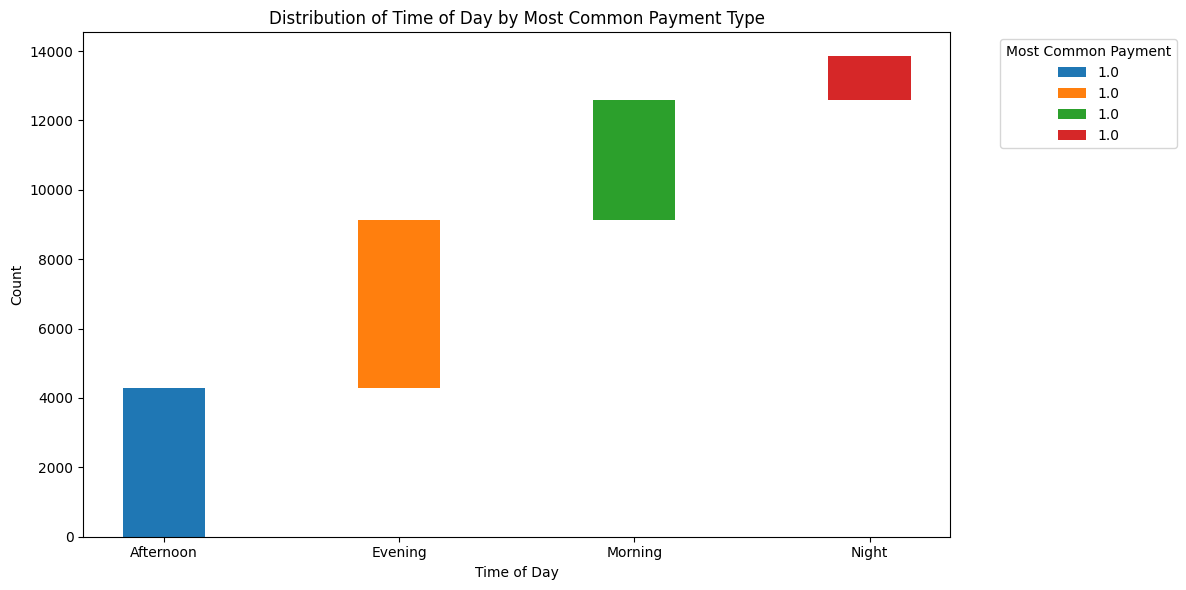

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_result is already populated with the aggregation result

# Extracting data
time_of_day = df_result['time_of_day']
most_common_payment = df_result['most_common_payment']
count = df_result['count']

# Plotting
bar_width = 0.35
index = np.arange(len(time_of_day))

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting stacked bars
bottom = None
for i in range(len(most_common_payment)):
    ax.bar(time_of_day[i], count[i], bar_width, bottom=bottom, label=most_common_payment[i])
    if bottom is None:
        bottom = count[i]
    else:
        bottom += count[i]

ax.set_xlabel('Time of Day')
ax.set_ylabel('Count')
ax.set_title('Distribution of Time of Day by Most Common Payment Type')
ax.legend(title='Most Common Payment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# g)Calculate Average Tip amount per passenger count
# Aggregation pipeline to calculate the average tip amount per passenger count
pipeline = [
    {
        '$group': {
            '_id': '$passenger_count',
            'avg_tip_amount': {'$avg': '$tip_amount'}
        }
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Print the result
for row in result:
    print(f"Passenger Count: {row['_id']}, Average Tip Amount: {row['avg_tip_amount']}")

Passenger Count: 2, Average Tip Amount: 1.8270060893098783
Passenger Count: 1, Average Tip Amount: 1.836660088801184
Passenger Count: 5, Average Tip Amount: 1.911195530726257
Passenger Count: 0, Average Tip Amount: 1.876243093922652
Passenger Count: 6, Average Tip Amount: 1.9905123674911662
Passenger Count: 3, Average Tip Amount: 1.7564462809917356
Passenger Count: 4, Average Tip Amount: 1.9713661202185793


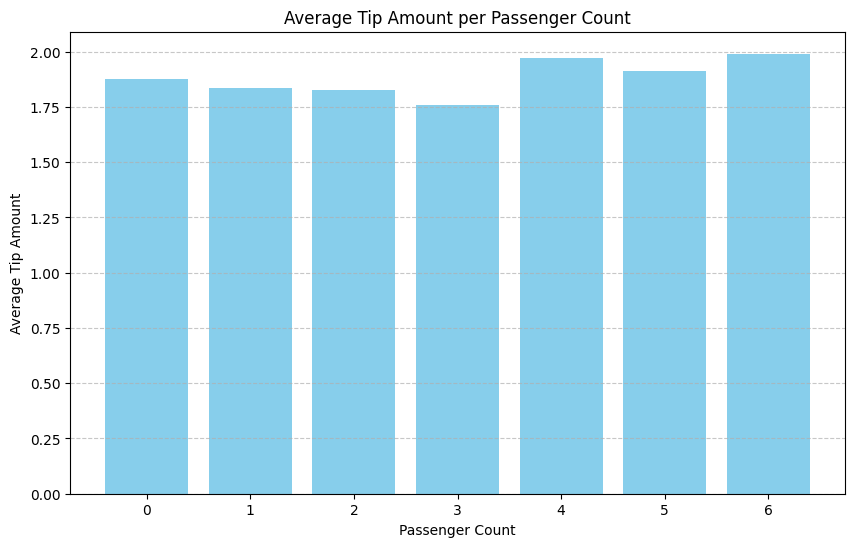

In [ ]:
import matplotlib.pyplot as plt

# Define lists to store passenger counts and average tip amounts
passenger_counts = []
avg_tip_amounts = []

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Store the results in lists
for row in result:
    passenger_counts.append(row['_id'])
    avg_tip_amounts.append(row['avg_tip_amount'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(passenger_counts, avg_tip_amounts, color='skyblue')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Amount')
plt.title('Average Tip Amount per Passenger Count')
plt.xticks(passenger_counts)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [20]:
# h) What are the best 5 locations for drivers to pick up passengers from?

pipeline = [
    {
        '$group': {
            '_id': '$pickup_location_id',  # Group by pickup location
            'pickup_count': {'$sum': 1}  # Count the number of pickups at each location
        }
    },
    {
        '$sort': {'pickup_count': -1}  # Sort by pickup count in descending order
    },
    {
        '$limit': 5  # Limit to top 5 locations
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)
print(result)

# Print the top 5 pickup locations
for idx, row in enumerate(result, 1):
    location_id = row['_id']
    location_info = zone_data[zone_data['zone_id'] == location_id].iloc[0]  # Search the DataFrame for the location ID

    # Print the information if the location is found
    if not location_info.empty:
        print(f"{idx}. Pickup Location: {location_id}, Pickup Count: {row['pickup_count']}")
        print("Zone ID:", location_info['zone_id'])
        print("Zone Name:", location_info['zone_name'])
        print("Borough:", location_info['borough'])
        print("Zone Geometry:", location_info['zone_geom'])
        print()
    else:
        print(f"No information found for pickup location with ID: {location_id}")



1. Pickup Location: 237.0, Pickup Count: 817
Zone ID: 237
Zone Name: Upper East Side South
Borough: Manhattan
Zone Geometry: POLYGON((-73.9656696 40.7628045559999, -73.9652132809999 40.7634313589999, -73.9647554489999 40.7640570699999, -73.9642979039999 40.7646819869999, -73.9638429109999 40.765309686, -73.9634015409999 40.7659111909999, -73.962928658 40.7665586279999, -73.9624699899999 40.7671849329999, -73.9620141309999 40.7678123079999, -73.9615582429998 40.7684376119999, -73.9611017069999 40.7690593189999, -73.9606018059998 40.7697491869999, -73.9601095519999 40.7704322109999, -73.959644408 40.7710642659999, -73.9591817999999 40.7716968239999, -73.9587170739999 40.7723316749999, -73.958255349 40.7729653369999, -73.9598568179999 40.7736427679999, -73.9613679269998 40.7742787609999, -73.9614758119999 40.7743240109999, -73.9615845389999 40.7743687839999, -73.9630876029998 40.7750028419999, -73.9646873579999 40.7756770819999, -73.9651474539998 40.7750442319998, -73.9656096859999 40.774

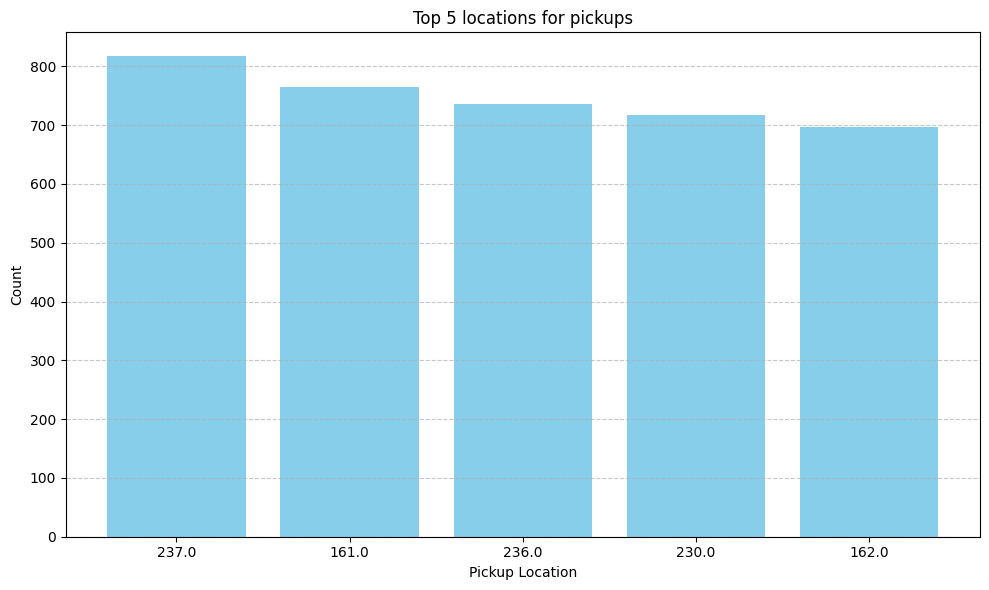

In [ ]:
import matplotlib.pyplot as plt

# Define lists to store pickup counts and pickup locations
pickup_location = []
pickup_count = []

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Store the results in lists
for row in result:
    pickup_location.append(row['_id'])
    pickup_count.append(row['pickup_count'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(range(len(pickup_location)), pickup_count, color='skyblue')
plt.xlabel('Pickup Location')
plt.ylabel('Count')
plt.title('Top 5 locations for pickups')
plt.xticks(range(len(pickup_location)), pickup_location)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<ipython-input-24-380081ae2789>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_subset['trip_distance'] = merged_df_subset.apply(calculate_distance, axis=1)
<ipython-input-24-380081ae2789>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_subset['total_trip_cost'] = merged_df_subset['fare_amount'] + merged_df_subset['extra'] + \
<ipython-input-24-380081ae2789>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

   vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0          1  2018-05-11 17:40:16  2018-05-11 17:55:35                1   
1          2  2018-03-22 23:01:41  2018-03-22 23:25:36                1   
2          2  2018-07-24 09:58:45  2018-07-24 10:22:37                1   
3          2  2018-12-21 18:28:55  2018-12-21 18:35:45                1   
5          1  2018-09-11 14:33:24  2018-09-11 15:25:48                1   

   trip_distance  payment_type  fare_amount  extra  mta_tax  tip_amount  ...  \
0       1.175313             1         11.5    1.0      0.5        0.00  ...   
1       6.103429             1         28.5    0.5      0.5        5.96  ...   
2       1.484561             1         15.5    0.0      0.5        1.50  ...   
3       1.129746             2          6.0    1.0      0.5        0.00  ...   
5       4.777150             1         33.0    0.0      0.5        6.75  ...   

   zone_id_pickup    zone_name_pickup  borough_pickup  \
0          

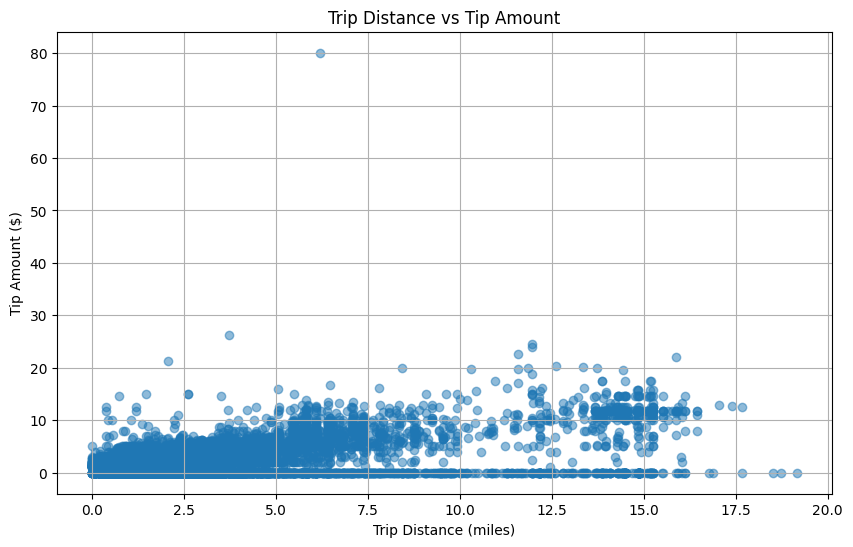

In [ ]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
# Function to extract coordinates from multipolygon format
def extract_coordinates(multipolygon_str):
    # Remove the 'POLYGON' prefix and parentheses
    multipolygon_str = multipolygon_str.replace('MULTIPOLYGON', '').replace('(', '').replace(')', '')
    # Split by commas to get individual polygons
    polygons = multipolygon_str.split('),(')
    # Extract coordinates from each polygon
    coordinates = []
    for polygon in polygons:
        # Split by commas to get individual points
        points = polygon.split(',')
        # Extract latitude and longitude from each point
        polygon_coords = []
        for point in points:
            try:
                lat, lon = point.strip().split()
                polygon_coords.append((float(lon), float(lat)))
            except ValueError:
                pass  # Skip invalid coordinates
        coordinates.extend(polygon_coords)
    return coordinates

# Calculate trip distance from pickup to dropoff coordinates
def calculate_distance(row):
    # Extract pickup and dropoff coordinates
    pickup_coordinates = extract_coordinates(row['zone_geom_pickup'])
    dropoff_coordinates = extract_coordinates(row['zone_geom_dropoff'])
    # Calculate distance
    return geodesic(pickup_coordinates[0], dropoff_coordinates[0]).miles

# Use only the first 20,000 rows in the trip_data
trip_data_subset = trip_data.head(20000)

# Calculate trip distance for the subset
trip_data_subset['trip_distance'] = trip_data_subset.apply(calculate_distance, axis=1)

# Calculate total trip cost
trip_data_subset['total_trip_cost'] = trip_data_subset['fare_amount'] + trip_data_subset['extra'] + \
                                      trip_data_subset['mta_tax'] + trip_data_subset['tip_amount'] + \
                                      trip_data_subset['tolls_amount'] + trip_data_subset['imp_surcharge']

# Filter data based on trip distance and total trip cost criteria
trip_data_filtered = trip_data_subset[
    (trip_data_subset['trip_distance'] > 0) &
    (trip_data_subset['trip_distance'] < 100) &
    (trip_data_subset['total_trip_cost'] >= 2.5) &
    (trip_data_subset['total_trip_cost'] <= 250)
]


# Create new feature: tip percentage
trip_data_filtered['tip_percentage'] = (trip_data_filtered['tip_amount'] / trip_data_filtered['total_trip_cost']) * 100

# Display the DataFrame with the new feature and filtered data
print(trip_data_filtered.head())

# Plot trip distance vs tip amount
plt.figure(figsize=(10, 6))
plt.scatter(trip_data_filtered['trip_distance'], trip_data_filtered['tip_amount'], alpha=0.5)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.title('Trip Distance vs Tip Amount')
plt.grid(True)
plt.show()




# yes they are a little positively correlated as shown in the scatterplot